### Basic regression: Predict fuel efficiency 

In a regression problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This tutorial uses the classic Auto MPG dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. To do this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

This example uses the Keras API. (Visit the Keras tutorials and guides to learn more.)

- source - https://www.tensorflow.org/tutorials/keras/regression



In [200]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [201]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.15.0


### The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/)

### Get the data

First download and import the dataset using pandas:

In [202]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [203]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Shape Dataset

In [204]:
dataset.shape

(398, 8)

### Clean the data

The dataset contains a few unknown values:

In [205]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Drop those rows to keep this initial tutorial simple:

In [206]:
dataset = dataset.dropna()

In [207]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [208]:
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [209]:
#dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [210]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

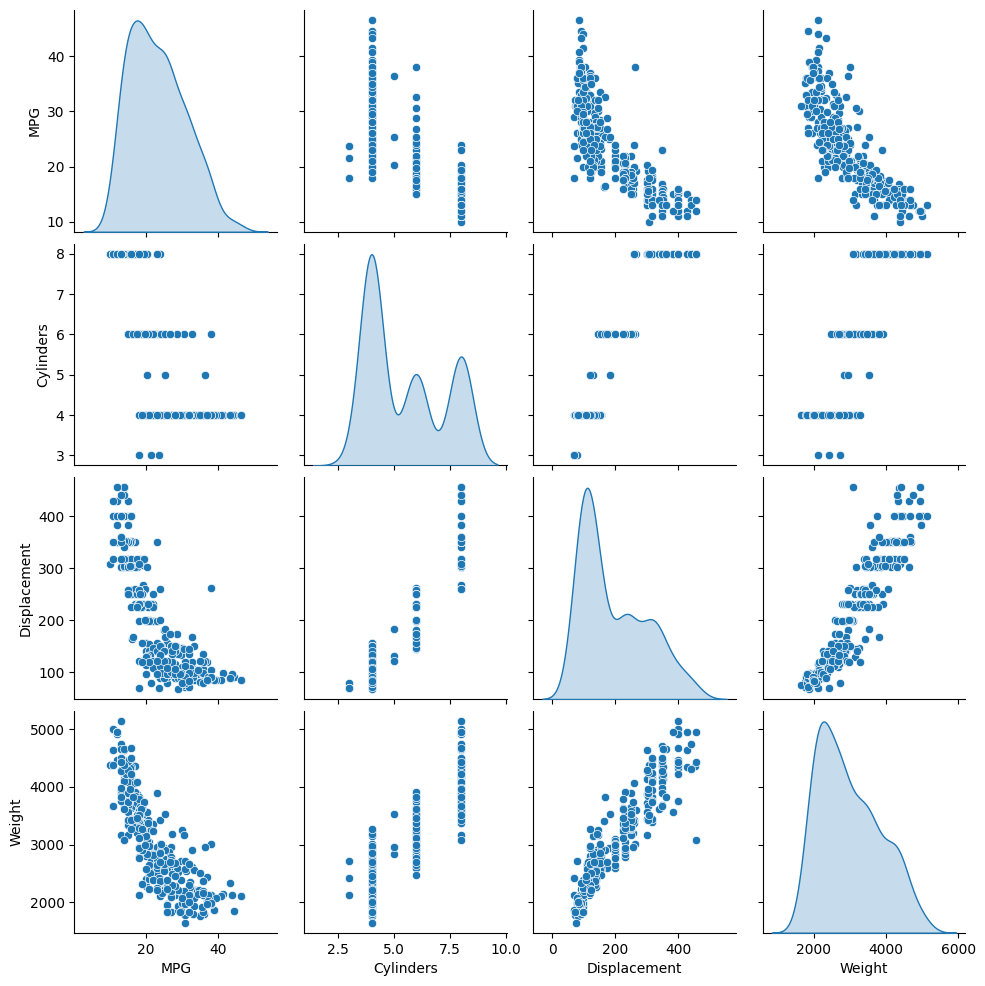

In [211]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

### Normalization

In [212]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [213]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Origin,1.573248,0.800988


### The Normalization layer

In [214]:
train_dataset.dtypes

MPG             float64
Cylinders         int64
Displacement    float64
Horsepower      float64
Weight          float64
Acceleration    float64
Model Year        int64
Origin            int64
dtype: object

In [215]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [216]:
normalizer.adapt(np.array(train_features))

In [217]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    1.573]]


In [218]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.72]]


In [219]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [220]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_9 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_11 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [221]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 167ms/step


array([[-0.546],
       [-0.308],
       [ 1.008],
       [-0.766],
       [-0.693],
       [-0.272],
       [-0.821],
       [-0.693],
       [-0.18 ],
       [-0.308]], dtype=float32)

In [222]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [223]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 4.26 s, sys: 172 ms, total: 4.43 s
Wall time: 8.43 s


In [224]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.803297,4.187287,95
96,3.805537,4.192841,96
97,3.804397,4.177203,97
98,3.811129,4.168006,98
99,3.805613,4.176549,99


In [225]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

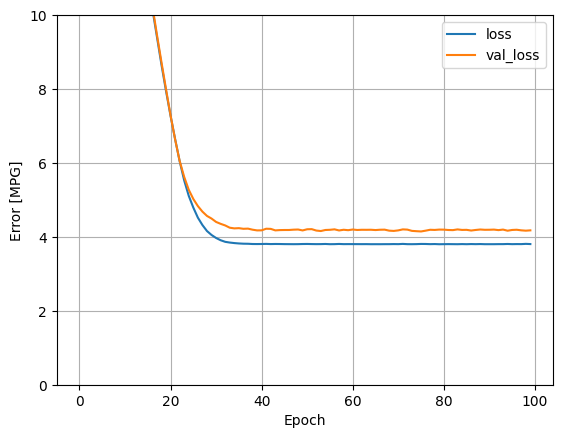

In [226]:
plot_loss(history)

In [227]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [228]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 4ms/step


In [229]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

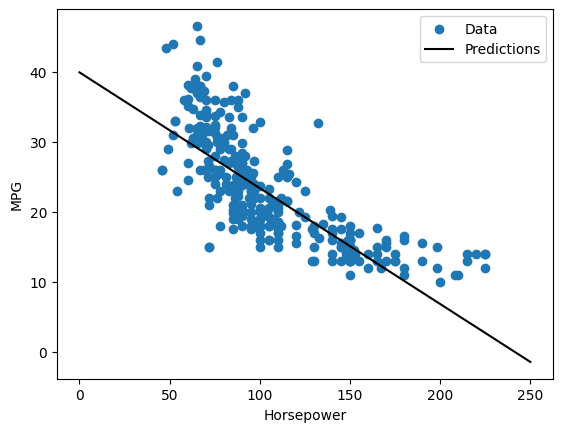

In [230]:
plot_horsepower(x, y)

### Linear regression with multiple inputs

In [231]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [232]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 81ms/step


array([[ 0.736],
       [-0.368],
       [ 0.56 ],
       [-0.893],
       [-0.981],
       [-0.389],
       [-0.905],
       [-0.981],
       [ 0.597],
       [ 0.504]], dtype=float32)

In [233]:
linear_model.layers[1].kernel

<tf.Variable 'dense_12/kernel:0' shape=(7, 1) dtype=float32, numpy=
array([[ 0.458],
       [-0.766],
       [ 0.406],
       [-0.194],
       [ 0.178],
       [-0.644],
       [-0.298]], dtype=float32)>

In [234]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [235]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 4.26 s, sys: 219 ms, total: 4.48 s
Wall time: 7.06 s


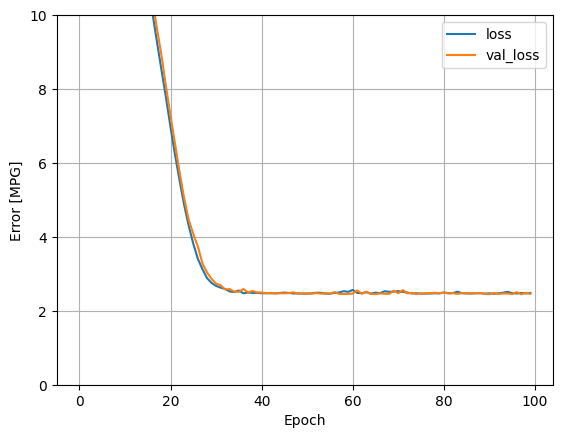

In [236]:
plot_loss(history)

In [237]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

### Regression with a deep neural network (DNN)

In [238]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regression using a DNN and a single input

In [239]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [240]:
dnn_horsepower_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_9 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_13 (Dense)            (None, 64)                128       
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4356 (17.02 KB)
Trainable params: 4353 (17.00 KB)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [241]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 4.78 s, sys: 227 ms, total: 5.01 s
Wall time: 8.46 s


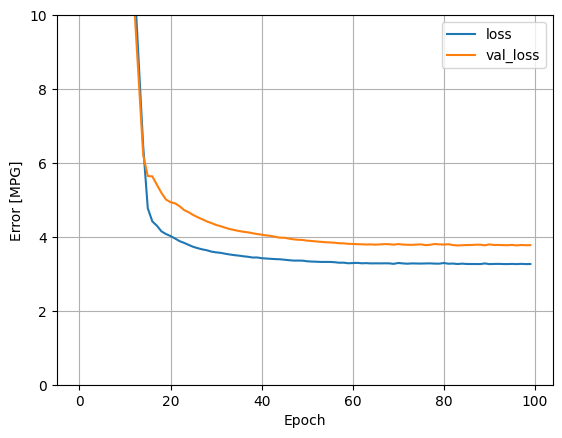

In [242]:
plot_loss(history)

In [243]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 2ms/step


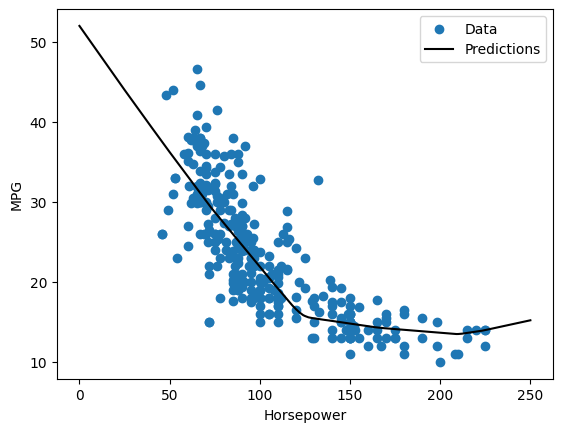

In [244]:
plot_horsepower(x, y)

In [245]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

In [246]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_10"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 normalization_8 (Normaliza  (None, 7)                 15        
 tion)                                                           
                                                                 
 dense_16 (Dense)            (None, 64)                512       
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4752 (18.57 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 15 (64.00 Byte)
_________________________________________________________________


In [247]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 4.71 s, sys: 307 ms, total: 5.01 s
Wall time: 6.67 s


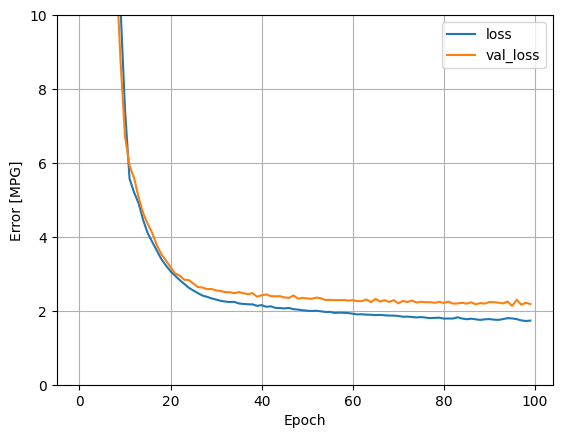

In [248]:
plot_loss(history)

In [249]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [250]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.654088
linear_model,2.431657
dnn_horsepower_model,2.943132
dnn_model,1.810202


3/3 [==============================] - 0s 2ms/step


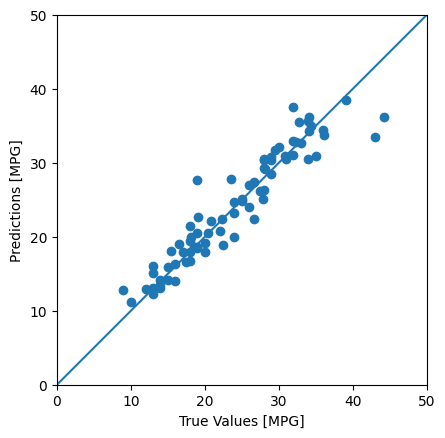

In [251]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

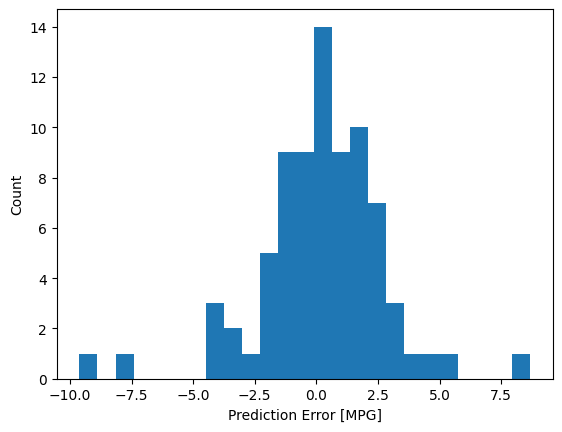

In [252]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [253]:
###################################

### Generate dataset to world around with deep learning.

- How we can build a model and improve it.

In [360]:
import random

In [385]:
n = 80
X = []
y = []

limit = 0.5

for i in range(0, n):
    errx = round(random.uniform(0, limit), 2)
    X.append(i+errx)

    erry = round(random.uniform(0, limit), 2)
    y.append(2 * i + erry)

X_train = np.array(X)
y_train = np.array(y)

X_train, y_train



(array([ 0.1 ,  1.29,  2.46,  3.19,  4.03,  5.37,  6.14,  7.25,  8.01,
         9.12, 10.32, 11.37, 12.42, 13.24, 14.25, 15.03, 16.46, 17.04,
        18.26, 19.34, 20.36, 21.44, 22.25, 23.19, 24.1 , 25.09, 26.47,
        27.12, 28.47, 29.24, 30.49, 31.17, 32.26, 33.04, 34.31, 35.45,
        36.04, 37.4 , 38.39, 39.36, 40.48, 41.02, 42.18, 43.46, 44.49,
        45.1 , 46.37, 47.4 , 48.48, 49.44, 50.48, 51.22, 52.35, 53.47,
        54.16, 55.29, 56.3 , 57.16, 58.44, 59.38, 60.47, 61.37, 62.09,
        63.1 , 64.37, 65.22, 66.4 , 67.48, 68.07, 69.22, 70.06, 71.48,
        72.48, 73.21, 74.07, 75.35, 76.34, 77.49, 78.45, 79.28]),
 array([  0.35,   2.46,   4.48,   6.05,   8.17,  10.02,  12.17,  14.48,
         16.2 ,  18.28,  20.23,  22.2 ,  24.47,  26.04,  28.47,  30.32,
         32.41,  34.21,  36.1 ,  38.48,  40.48,  42.36,  44.19,  46.13,
         48.2 ,  50.3 ,  52.01,  54.49,  56.41,  58.29,  60.29,  62.23,
         64.43,  66.43,  68.26,  70.3 ,  72.29,  74.1 ,  76.3 ,  78.41,
      

In [386]:
n = 100
X = []
y = []

for i in range(80, n):
    errx = round(random.uniform(0, limit), 2)
    X.append(i+errx)

    erry = round(random.uniform(0, limit), 2)
    y.append(2 * i + erry)

X_test = np.array(X)
y_test = np.array(y)

X_test , y_test 

(array([80.16, 81.13, 82.19, 83.48, 84.46, 85.27, 86.18, 87.39, 88.19,
        89.09, 90.07, 91.28, 92.15, 93.07, 94.02, 95.39, 96.36, 97.14,
        98.46, 99.39]),
 array([160.07, 162.43, 164.29, 166.26, 168.31, 170.07, 172.06, 174.47,
        176.3 , 178.42, 180.14, 182.04, 184.23, 186.46, 188.32, 190.02,
        192.35, 194.02, 196.03, 198.39]))

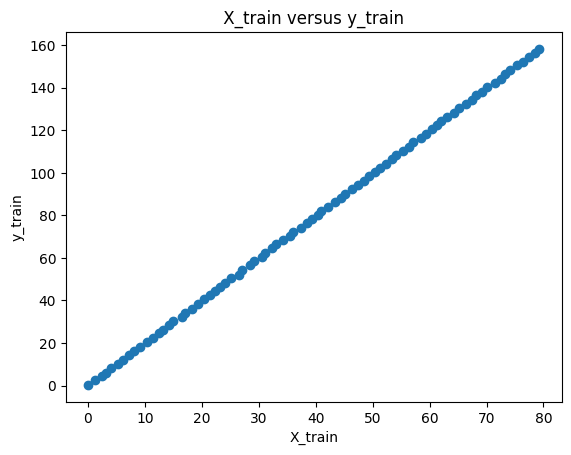

In [387]:
plt.scatter(X_train, y_train)
plt.xlabel('X_train')
plt.ylabel('y_train')
plt.title(' X_train versus y_train ')
plt.show()

In [388]:
#Set random seed 
tf.random.set_seed(42) 

# Create a model (same as above) 
model = tf.keras.Sequential([ tf.keras.layers.Dense(1) ]) 

# Compile model (same as above) 
model.compile(loss=tf.keras.losses.mae, 
              optimizer=tf.keras.optimizers.SGD(), 
              metrics=["mae"]) 

# Fit model (this time we'll train for longer) 
model.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=50) # train for 100 epochs not 10

Epoch 1/50


3/3 [==============================] - 1s 6ms/step - loss: 8.2506 - mae: 8.2506
Epoch 2/50
3/3 [==============================] - 0s 15ms/step - loss: 7.5953 - mae: 7.5953
Epoch 3/50
3/3 [==============================] - 0s 8ms/step - loss: 7.9925 - mae: 7.9925
Epoch 4/50
3/3 [==============================] - 0s 4ms/step - loss: 7.4154 - mae: 7.4154
Epoch 5/50
3/3 [==============================] - 0s 18ms/step - loss: 7.9456 - mae: 7.9456
Epoch 6/50
3/3 [==============================] - 0s 6ms/step - loss: 7.0565 - mae: 7.0565
Epoch 7/50
3/3 [==============================] - 0s 5ms/step - loss: 8.9261 - mae: 8.9261
Epoch 8/50
3/3 [==============================] - 0s 9ms/step - loss: 5.9321 - mae: 5.9321
Epoch 9/50
3/3 [==============================] - 0s 4ms/step - loss: 9.7837 - mae: 9.7837
Epoch 10/50
3/3 [==============================] - 0s 6ms/step - loss: 6.6244 - mae: 6.6244
Epoch 11/50
3/3 [==============================] - 0s 5ms/step - loss: 8.4048 - mae: 8.4048
Epoch 

In [389]:
model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_71 (Dense)            (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


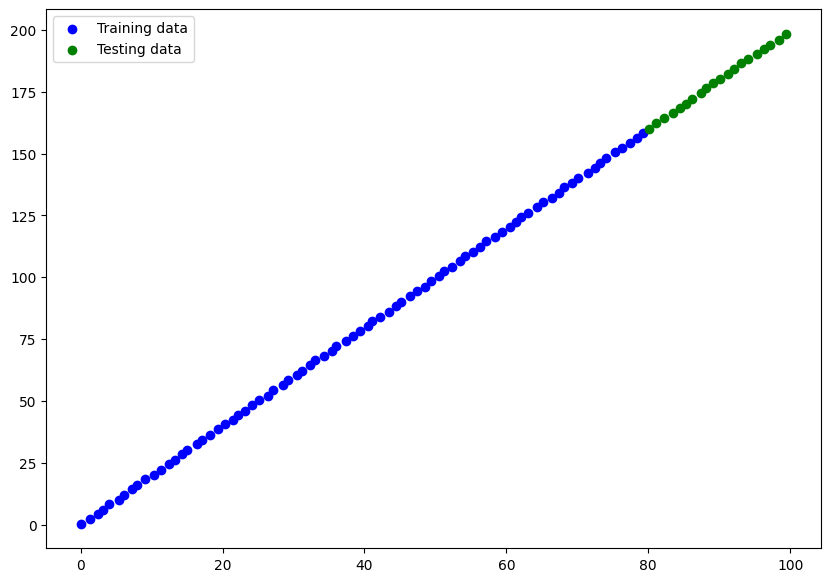

In [390]:
plt.figure(figsize=(10, 7)) 

# Plot training data in blue 
plt.scatter(X_train, y_train, c='b', label='Training data') 

# Plot test data in green 
plt.scatter(X_test, y_test, c='g', label='Testing data') 

# Show the legend 
plt.legend();

In [391]:
# Make predictions 
y_preds = model.predict(X_test)
y_preds

1/1 [==============================] - 0s 111ms/step


array([[126.805],
       [128.339],
       [130.016],
       [132.057],
       [133.607],
       [134.888],
       [136.328],
       [138.242],
       [139.508],
       [140.932],
       [142.482],
       [144.396],
       [145.772],
       [147.228],
       [148.731],
       [150.898],
       [152.433],
       [153.667],
       [155.755],
       [157.226]], dtype=float32)

In [392]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=y_preds): 
    """ Plots training data, test data and compares predictions. """ 
    plt.figure(figsize=(10, 7)) 
    # Plot training data in blue 
    plt.scatter(train_data, train_labels, c="b", label="Training data") 
    # Plot test data in green 
    plt.scatter(test_data, test_labels, c="g", label="Testing data") 
    
    # Plot the predictions in red (predictions were made on the test data) 
    plt.scatter(test_data, predictions, c="r", label="Predictions") 
    
    # Show the legend 
    plt.legend();

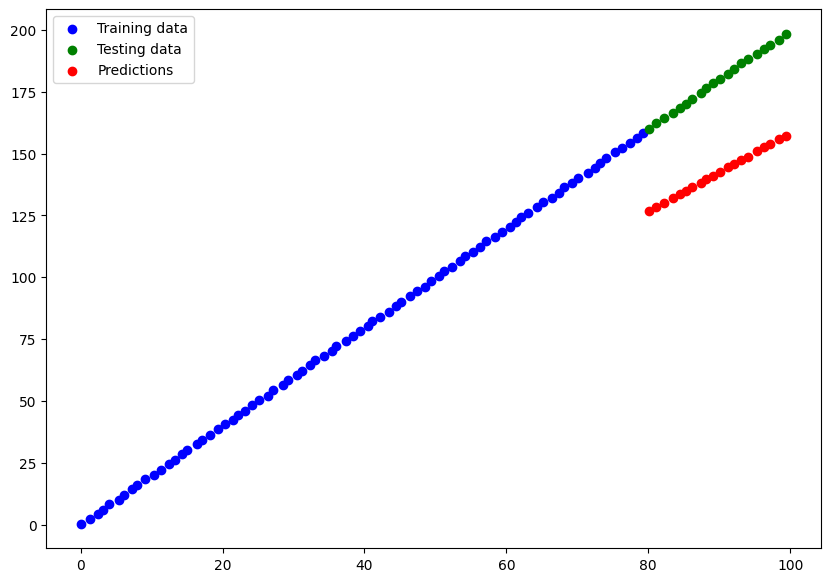

In [393]:
plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=y_preds)

In [394]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 242ms/step - loss: 37.2686 - mae: 37.2686


[37.268585205078125, 37.268585205078125]

## Running experiments to improve a model

- model_1 - same as original model, 1 layer, trained for 100 epochs.

In [395]:
# Set random seed 
tf.random.set_seed(42) 

# Replicate original model 
model_1 = tf.keras.Sequential([ tf.keras.layers.Dense(1),
                                tf.keras.layers.Input((128, None, 6)) ]) 

# Compile the model 
model_1.compile(loss=tf.keras.losses.mae, 
                optimizer=tf.keras.optimizers.SGD(), 
                metrics=['mae']) 

# Fit the model 
model_1.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=100)

Epoch 1/100


3/3 [==============================] - 1s 5ms/step - loss: 53.2236 - mae: 53.2236
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 10.2456 - mae: 10.2456
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 6.6347 - mae: 6.6347
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 8.9459 - mae: 8.9459
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 6.5605 - mae: 6.5605
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 8.8403 - mae: 8.8403
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 7.6025 - mae: 7.6025
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 7.7651 - mae: 7.7651
Epoch 9/100
3/3 [==============================] - 0s 6ms/step - loss: 8.4096 - mae: 8.4096
Epoch 10/100
3/3 [==============================] - 0s 4ms/step - loss: 6.7825 - mae: 6.7825
Epoch 11/100
3/3 [==============================] - 0s 4ms/step - loss: 8.9080 - mae: 8

1/1 [==============================] - 0s 153ms/step


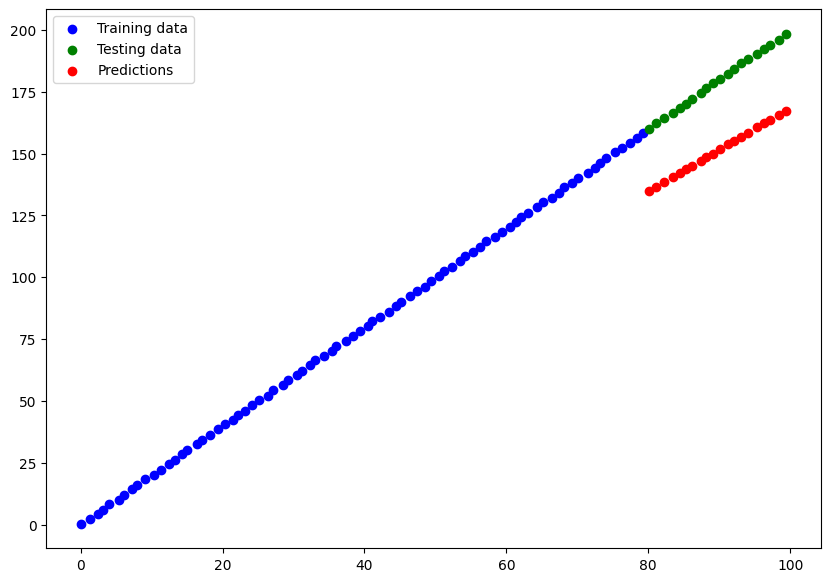

In [396]:
# Make and plot predictions for model_1 
y_preds_1 = model_1.predict(X_test) 

plot_predictions(predictions=y_preds_1)

- ```Build model_2```: This time we'll add an extra dense layer (so now our model will have 2 layers) whilst keeping everything else the same.

In [397]:
# Set random seed 
tf.random.set_seed(42) 

# Replicate model_1 and add an extra layer 
model_2 = tf.keras.Sequential([ tf.keras.layers.Dense(1), 
                               tf.keras.layers.Dense(1) # add a second layer 
                               ]) 

# Compile the model 
model_2.compile(loss=tf.keras.losses.mae, 
                optimizer=tf.keras.optimizers.SGD(), 
                metrics=['mae']) 

# Fit the model 
model_2.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=100, verbose=0) # set verbose to 0 for less output

1/1 [==============================] - 0s 225ms/step


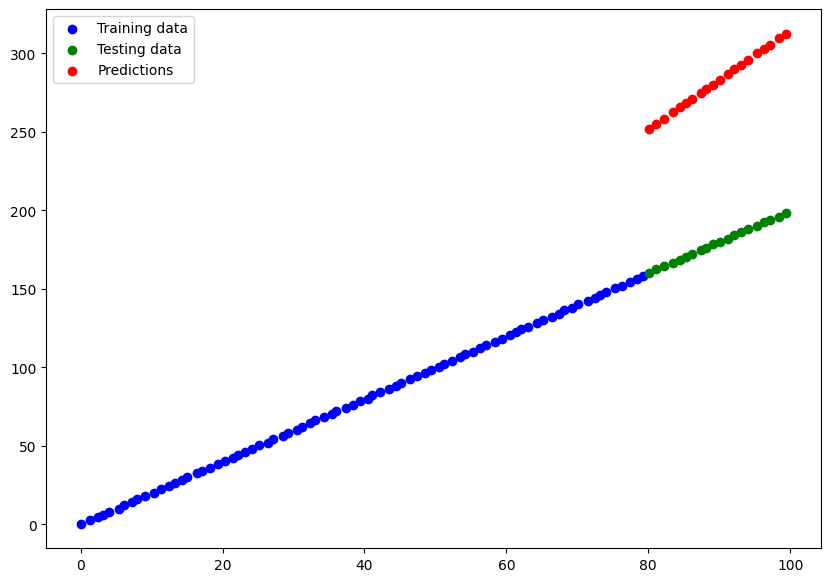

In [398]:
# Make and plot predictions for model_2 
y_preds_2 = model_2.predict(X_test)

plot_predictions(predictions=y_preds_2)

In [399]:
# Set random seed 
tf.random.set_seed(42) 

# Replicate model_2 
model_3 = tf.keras.Sequential([ tf.keras.layers.Dense(1), 
                                tf.keras.layers.Dense(1) ]) 

# Compile the model 
model_3.compile(loss=tf.keras.losses.mae, 
                optimizer=tf.keras.optimizers.SGD(), 
                metrics=['mae']) 

# Fit the model (this time for 500 epochs, not 100) 
model_3.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=500, verbose=0) # set verbose to 0 for less output

1/1 [==============================] - 0s 84ms/step


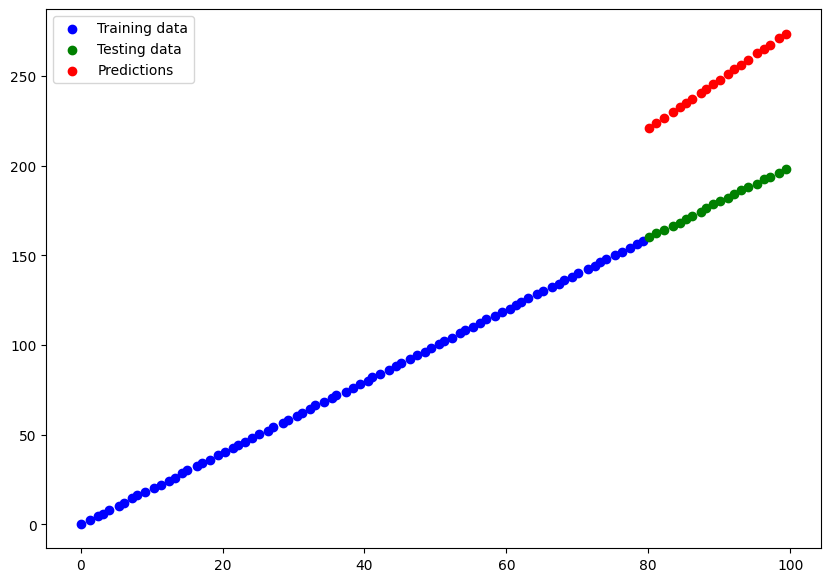

In [400]:
# Make and plot predictions for model_3 
y_preds_3 = model_3.predict(X_test) 

plot_predictions(predictions=y_preds_3)

In [401]:
# Set random seed 
tf.random.set_seed(42) 

model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(1,)),  # Hidden layer with 128 units
    tf.keras.layers.Dense(64, activation='relu'),  # Additional hidden layer with 64 units
    tf.keras.layers.Dense(32, activation='relu'),  # Additional hidden layer with 32 units
    tf.keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model
model_4.compile(optimizer='adam',
              loss='mean_squared_error',  # Use mean squared error for regression
              metrics=['mae'])   

In [402]:
# Assuming X_train and y_train are your input features and labels for training
# Assuming X_val and y_val are your input features and labels for validation

history = model_4.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2)  # 20% of the training data will be used for validation


Epoch 1/100
2/2 [==============================] - 1s 218ms/step - loss: 5010.8418 - mae: 61.1491 - val_loss: 18191.1855 - val_mae: 134.5929
Epoch 2/100
2/2 [==============================] - 0s 92ms/step - loss: 4651.7949 - mae: 58.9384 - val_loss: 17178.9297 - val_mae: 130.7945
Epoch 3/100
2/2 [==============================] - 0s 64ms/step - loss: 4417.2266 - mae: 57.3611 - val_loss: 16189.2812 - val_mae: 126.9710
Epoch 4/100
2/2 [==============================] - 0s 115ms/step - loss: 4149.0820 - mae: 55.6127 - val_loss: 15282.7637 - val_mae: 123.3649
Epoch 5/100
2/2 [==============================] - 0s 76ms/step - loss: 3919.1367 - mae: 54.0590 - val_loss: 14458.5234 - val_mae: 119.9920
Epoch 6/100
2/2 [==============================] - 0s 89ms/step - loss: 3704.8735 - mae: 52.5449 - val_loss: 13551.0664 - val_mae: 116.1653
Epoch 7/100
2/2 [==============================] - 0s 69ms/step - loss: 3471.4136 - mae: 50.8273 - val_loss: 12546.9297 - val_mae: 111.7783
Epoch 8/100
2/2 [=

1/1 [==============================] - 0s 119ms/step


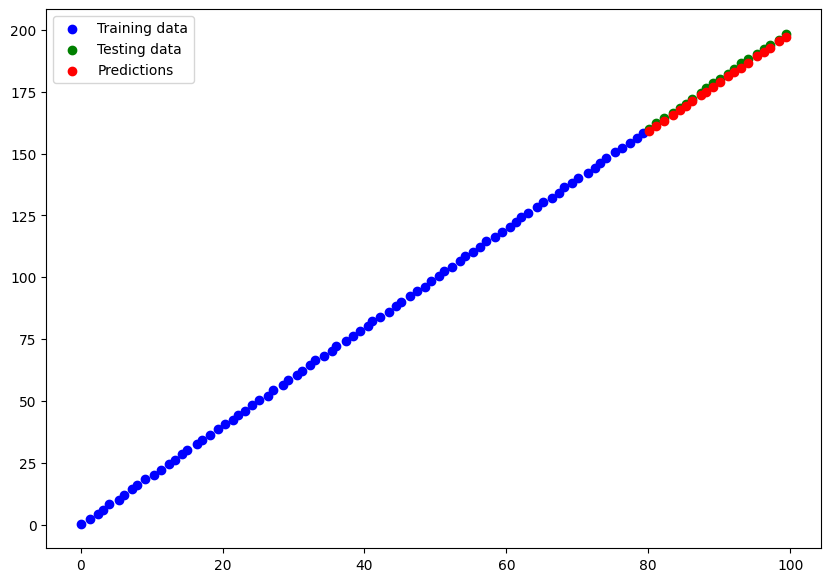

In [403]:
# Make and plot predictions for model_3 
y_preds_4 = model_4.predict(X_test) 

plot_predictions(predictions=y_preds_4)

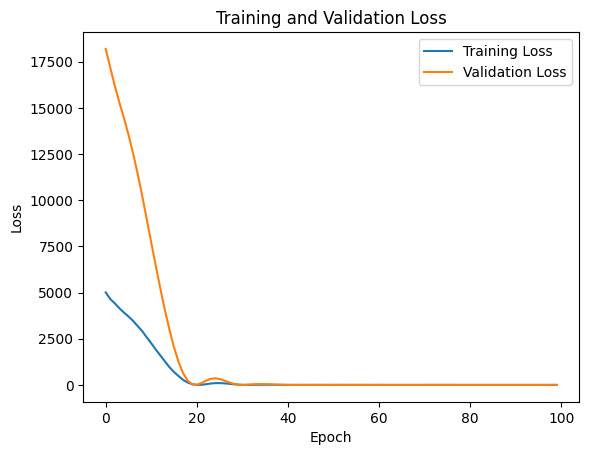

In [404]:
# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()